# Multiagents

- Agent = LLM+Tool and if there are multiple agents and interacting within themselves ato achive a task is called Multiagent Application. These agents interacts within themselves in two ways. 
    
- Supervisor (Manager–Worker) Architecture:
    - This architecture has one main agent (the supervisor) that controls or manages several specialized worker agents. 
    - The supervisor decides who should do what, sends tasks to workers, collects their results, and combines everything into a final answer. 
    - It is useful when tasks can be split—for example: planning → researching → writing → reviewing.
    - Example
        - A “Project Manager” AI assigns tasks to a “Research Agent,” “Coding Agent,” and “Editor Agent.” Each worker does its part, and the manager assembles the final outputs.
    - Supervison architecture can be extended to hierarchial architecture

- Network Agent (Decentralized / Peer-to-Peer) Architecture or Collaborative Agent
    - In this architecture, all agents act like peers in a network.
    - There is no central supervisor—agents communicate directly, exchange information, and collaborate to solve problems.
    - Each agent has its own skills and goals, and they coordinate by sending messages to each other
    - Example
        - A “Math Agent,” “Science Agent,” and “Language Agent” communicate together.
        - If a question involves both math and science, they share partial answers until they reach a final solution.

- https://github.com/langchain-ai/langgraph/tree/main/docs/docs/tutorials/multi_agent
- Each node uses Command to give instruction/information to other nodes 

## Network or Collaborative Agent: Solve complex mathematic summation such as ((3+5)*2(5/3)(6-4))/(4+5)*2

- We decompose the expression into addition/subtraction and multiplication/division tasks.
    - addition_expert: handles + and − operations
    - multiplication_expert: handles × and ÷ operations

#### SteUp

In [1]:
import os
from dotenv import load_dotenv
load_dotenv() # you can pass the absolute path to .env file

#store keys in the OS env
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

## Langsmith Tracking And Tracing
os.environ["LANGCHAIN_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"]="AgentiAICourse_01"
os.environ["LANGCHAIN_TRACING_V2"]="true"

#intiate chat model
from langchain_openai import ChatOpenAI
llm=ChatOpenAI(model="gpt-4o", temperature=0)

/Users/chandra/Courses/DataScience/NLP/AgenticAI/agenticaienv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Tools and Agents

In [3]:
from langchain.tools import tool
from langgraph.graph import MessagesState,START, END, StateGraph
from langgraph.types import Command
from typing import Literal

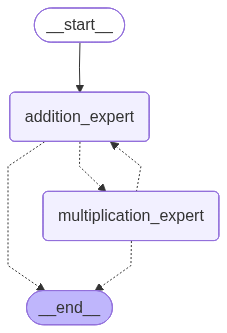

In [5]:
from langchain.tools import tool 

@tool 
def transfer_to_multiplication_expert(): 
    """Ask multiplication agent for help""" 
    return 

@tool 
def transfer_to_addition_expert(): 
    """Ask addition agent for help""" 
    return 

from langgraph.graph import MessagesState,START, END, StateGraph 
from langgraph.types import Command 
from typing import Literal 

def addition_expert(state:MessagesState)->Command[Literal["multiplication_expert","__end__"]]: 
    """ Addition expert """ 
    system_prompt = ( "You are an addition expert. " 
                     "Ask the multiplication expert for help with multiplication or division." 
                     "Always do your portion of calculation before the handoff." ) 
    messages = [{"role": "system", "content": system_prompt}] + state["messages"] 
    response = llm.bind_tools([transfer_to_multiplication_expert]).invoke(messages) 
    #incase tool call is involved then, pass the tool call details as tool message to next tool for better understanding 
    if len(response.tool_calls)>0: 
        tool_msg = { "role": "tool", 
                    "content": "Successfully transferred", 
                    "tool_call_id": response.tool_calls[-1]["id"], } 
        return Command(goto="multiplication_expert", update={"messages": [response, tool_msg]}) 
    return {"messages":[response]} 

def multiplication_expert(state:MessagesState)->Command[Literal["addition_expert","__end__"]]: 
    """ Multiplication expert """ 
    system_prompt = ( "You are a multiplication expert, you can ask an addition expert for help with addition and substraction. " 
                     "Always do your portion of calculation before the handoff." ) 
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    response = llm.bind_tools([transfer_to_addition_expert]).invoke(messages) 
    #incase tool call is involved then, pass the tool call details as tool message to next tool for better understanding 
    if len(response.tool_calls)>0: 
        tool_msg = { "role": "tool", 
                    "content": "Successfully transferred", 
                    "tool_call_id": response.tool_calls[-1]["id"], } 
        return Command(goto="addition_expert", update={"messages": [response, tool_msg]}) 
    
    return {"messages":[response]} 


graph=StateGraph(MessagesState)
graph.add_node("addition_expert",addition_expert)
graph.add_node("multiplication_expert",multiplication_expert)
graph.add_edge(START, "addition_expert")
app=graph.compile()
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [8]:
app.invoke({"messages": [("user", "Solve ((3+5)*2")]})

{'messages': [HumanMessage(content='Solve ((3+5)*2', additional_kwargs={}, response_metadata={}, id='24d525b0-9889-4fa5-9ad6-e457dd9a3ac2'),
  AIMessage(content="First, I'll handle the addition part of the expression:\n\n\\(3 + 5 = 8\\)\n\nNow, the expression becomes \\(8 \\times 2\\). I'll ask the multiplication expert to help with this multiplication.", additional_kwargs={'tool_calls': [{'id': 'call_camU8OUWO6DAq8NxIz6YyPXo', 'function': {'arguments': '{}', 'name': 'transfer_to_multiplication_expert'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 61, 'prompt_tokens': 77, 'total_tokens': 138, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_e819e3438b', 'id': 'chatcmpl-Cmdja9fr5l7GeCPnOR5Q2TJjMEwjM', 'service_tier': 'def

#### Collboartive agents using router approach using router appraoch:

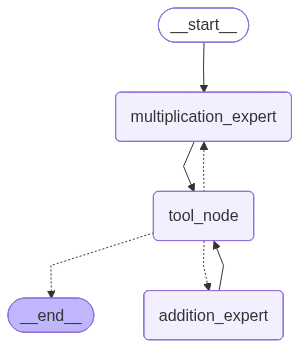

In [9]:
from langchain_core.messages import AnyMessage,AIMessage, HumanMessage
from typing_extensions import TypedDict, Annotated
from typing import List
import operator

class MessagesState(TypedDict):
    messages: Annotated[List[AnyMessage], operator.add]

@tool
def transfer_to_addition_expert() -> str:
    """Ask addition agent for help"""
    return "handoff_to_addition_expert"

@tool
def transfer_to_multiplication_expert() -> str:
    """Ask multiplication agent for help"""
    return "handoff_to_multiplication_expert"


def multiplication_expert(state: MessagesState):
    system_prompt = (
        "You are a multiplication expert. "
        "Do multiplication/division. "
        "Call transfer_to_addition_expert if addition is needed."
    )

    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    response = llm.bind_tools([transfer_to_addition_expert]).invoke(messages)

    return {"messages": [response]}

def addition_expert(state: MessagesState):
    system_prompt = (
        "You are a addition expert. "
        "Do Solve all addition and subtraction first"
        "Call transfer_to_multiplication_expert if addition is needed."
    )

    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    response = llm.bind_tools([transfer_to_multiplication_expert]).invoke(messages)

    return {"messages": [response]}

from langgraph.prebuilt import ToolNode

tools = [transfer_to_addition_expert, transfer_to_multiplication_expert]
tool_node = ToolNode(tools)

def router(state: MessagesState):
    # Traverse messages backwards to find last AIMessage
    for msg in reversed(state["messages"]):
        if isinstance(msg, AIMessage):
            if msg.tool_calls:
                tool_name = msg.tool_calls[0]["name"]
                if tool_name == "transfer_to_addition_expert":
                    return "addition_expert"
                if tool_name == "transfer_to_multiplication_expert":
                    return "multiplication_expert"
            break

    return END


workflow = StateGraph(MessagesState)

workflow.add_node("multiplication_expert", multiplication_expert)
workflow.add_node("addition_expert", addition_expert)
workflow.add_node("tool_node", tool_node)

workflow.add_edge(START, "multiplication_expert")
workflow.add_edge("multiplication_expert", "tool_node")
workflow.add_edge("addition_expert", "tool_node")

workflow.add_conditional_edges(
    "tool_node",
    router,
    {
        "addition_expert": "addition_expert",
        "multiplication_expert": "multiplication_expert",
        END: END,
    },
)

app = workflow.compile()
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [10]:
from langchain_core.messages import HumanMessage

app.invoke({
    "messages": [HumanMessage(content="Solve ((3+5)*(6-4))/(4+5)*2")]
})

{'messages': [HumanMessage(content='Solve ((3+5)*(6-4))/(4+5)*2', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_BMYo6VvowLz84OpRpBEkZPRD', 'function': {'arguments': '{}', 'name': 'transfer_to_addition_expert'}, 'type': 'function'}, {'id': 'call_K3r3ksja05ORtCPflJm735O1', 'function': {'arguments': '{}', 'name': 'transfer_to_addition_expert'}, 'type': 'function'}, {'id': 'call_jwSo5WBTktYH58OomKYTTaAR', 'function': {'arguments': '{}', 'name': 'transfer_to_addition_expert'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 62, 'prompt_tokens': 79, 'total_tokens': 141, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a4d13246c5', 'id': 'chatcmpl-CmdrEKLRkqW0bLU

#### Let's do with real time tool:

GOAL: to pick the some data from the online and execute python code to visualise it

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
search_tool=TavilySearchResults(tavily_api_key=TAVILY_API_KEY)
search_tool.invoke("what is GDP of US in 2024", max_results=5)

/var/folders/73/6p2c9x657plc1fg5k7ttv41r0000gn/T/ipykernel_5506/1520315026.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  search_tool=TavilySearchResults(tavily_api_key=TAVILY_API_KEY)


[{'title': 'United States GDP',
  'url': 'https://tradingeconomics.com/united-states/gdp',
  'content': 'Summary\n   Stats\n   Forecast\n   Download\n       Image 1: CSV download buttonDownload Data\n       Image 2: Excel download buttonExcel Add-in\n       Image 3: API download buttonAPI Access\n\nThe Gross Domestic Product (GDP) in the United States was worth 29184.89 billion US dollars in 2024, according to official data from the World Bank. The GDP value of the United States represents 27.49 percent of the world economy. source: World Bank [...] GDP in the United States averaged 8865.89 USD Billion from 1960 until 2024, reaching an all time high of 29184.89 USD Billion in 2024 and a record low of 542.39 USD Billion in 1960. This page provides - United States GDP - actual values, historical data, forecast, chart, statistics, economic calendar and news. United States GDP - values, historical data and charts - was last updated on November of 2025. [...] | Related | Last | Previous | U

In [12]:
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

In [14]:
from langchain_experimental.utilities import PythonREPL
# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()

@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

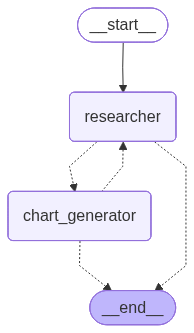

In [16]:
from typing import Literal

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END, START
from langgraph.types import Command



llm=ChatOpenAI(model="gpt-4o", temperature=0)


def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto


# Research agent and node
research_agent = create_react_agent(
    llm,
    tools=[search_tool],
    prompt=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ),
)


def research_node(state: MessagesState,) -> Command[Literal["chart_generator", END]]:
    result = research_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "chart_generator")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return Command(
        update={
            # share internal message history of research agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )

chart_agent = create_react_agent(llm,[python_repl_tool],prompt=make_system_prompt("You can only generate charts. You are working with a researcher colleague."),)


def chart_node(state: MessagesState) -> Command[Literal["researcher", END]]:
    result = chart_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "researcher")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="chart_generator"
    )
    return Command(
        update={
            # share internal message history of chart agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )


#put it all together and define the graph!
workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_edge(START, "researcher")
graph = workflow.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [19]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "Get the stock price of Tesla in last five days in USA and do line plot for it"
                "Once you make the chart, finish.",
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 15},
)
for s in events:
    print(s)
    print("----")

RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-nhFHyjGMImaNr9SR5pnG6pXK on tokens per min (TPM): Limit 30000, Used 10787, Requested 19394. Please try again in 362ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}